In [11]:
import numpy as np  # http://www.numpy.org
import matplotlib.pyplot as plt   # http://matplotlib.org
import math as M
from scipy.optimize import fsolve

In [12]:
############ Initilisation #################
############################################

#### Constants #####
L_x = 1e6          # [m] zonal extent 
L_y = 2e6          # [m] meridional extent 
A = L_x*L_y        # [m^2] surface area of interior 
P = 2*L_x+2*L_y    # [m] Perimeter 

g = 9.81           # [m/s^2] gravitational acceleration 
#C_p = 3.994e3      # [J/(kg K)] specific heat capacity of sea water 
c = 0.006          # [] bottom slope coefficient
s = 0.02           # [] average bottom slope around the perimeter of the marginal sea

#### Parameters ####
H = 1000           # [m] sill height 
f_0 = 1.2e-4       # [s^-1] Coriolis parameter 
Gamma = 20         # [W/(m^2 C)] Restoring strength 
#alpha_T = 0.2      # [kg m^-3 C^-1] thermal expansion coefficient; source: Ypma[2020]
#alpha_S = 0.8      # [kg m^-3] Haline expansion coefficient 
#T_1 = 8.87        # [Celsius] ingoing temperature 
T_A = 2.8          # [Celsius] Atmospheric temperature 
#ro = 1028          # [kg m^-3] density sea water 
S = 35             # [ppt] net evaporation minus precipitation
#S_1 = 35.2        # [g kg^-1] incoming salinity; source Lambert                          ! is ppt = g kg^-1 ???
E = -2e-8          # [m/s] a representative ocean salinity; source: Spall[2015]

#### functions ####
L = H/s           # [m] width of sloping topography of the boundary current 
#L = 75e3

For the root finding algorithm

\begin{align}
    C_p \psi_1(x) \frac{T_1^{x+1}-T_1^{x}}{\Delta x} + \Gamma (T_0-T_A) L_1 =0\\
    \frac{H_1^{x+1}-H_1^{x}}{\Delta x} + \frac{f_0 \rho_0}{g \Delta \rho_{\theta}(x)} \left(\frac{\kappa_{\theta}(x)}{H_1(x)}\frac{\Gamma (T_1(x)-T_A) L_1}{C_p (T_1(x)-T_0)H_1(x)}\right) = 0
\end{align}

with the following functions

\begin{align}
    \psi_1(x) = \frac{g \Delta\rho_{\theta}(x) H_1^2(x)}{2 f_0 \rho_{ref}}\\
    \Delta \rho_{\theta} (x) = \rho_{ref} \alpha_T(T_1(x)-T_0)\\
    \kappa_{\theta} =  \frac{c_{\theta} g \alpha (T_1(x)-T_0)H_1^2 (H_t-H_s)}{2 f W_c (H_t-H_1)}
\end{align}

combining those lead to these equations and set $T_1^{x+1}=T_1(x)$, $T_1^{x}=T_1(x-1)$ and $H_1^{x+1}=H_1(x)$, $H_1^{x}=H_1(x-1)$

\begin{align}
    C_p \left(\frac{g \left(\rho_{ref} \alpha_T(T_1(x)-T_0)\right) H_1^2(x)}{2 f_0 \rho_{ref}} \right) \frac{T_1(x)-T_1(x-1)}{\Delta x} + \Gamma (T_0-T_A) L_1 =0\\
    \frac{H_1(x)-H_1(x-1)}{\Delta x} + \frac{f_0 \rho_0}{g \left(\rho_{ref} \alpha_T(T_1(x)-T_0)\right)} \left[\frac{\left(\frac{c_{\theta} g \alpha (T_1(x)-T_0)H_1^2(x) (H_t-H_s)}{2 f W_c (H_t-H_1(x))}\right)}{H_1(x)}\frac{\Gamma (T_1(x)-T_A) L_1}{C_p (T_1(x)-T_0)H_1(x)}\right] = 0
\end{align}



In [29]:
c_theta = 0.007    # [] eddy coefficient halocline
alpha = 1e-4       # [1/C] thermal expansion coefficient
C_p = 4.2e6        # [J/(m^3*C)]
H_t = 1e3          # [m] depth interior
H_s = 2e2          # [m] depth shelves
W_c = 1e5          # [m] width slope
rho_0 = 1028     # [kg m^-3] reference density sea water 

steps=100          # test values
Dx=10              # test values

T_0 = np.zeros(steps)
H_1 = np.zeros(steps)
T_1 = np.zeros(steps)


T_1[0] = 8.87 
H_1[0] = 35.2 
T_0[0] = 5.3
integral=0.0

for i in range(1,steps-1):
    integral=integral+(c_theta*g*alpha*(T_1[i-1]-T_0[i-1])*H_1[i-1]**2*(H_t-H_s))/(2*f_0*W_c*(H_t-H_1[i-1]))*(T_1[i-1]-T_0[i-1])
    T_0[i]=T_A+(C_p)/(Gamma*A)*integral
    def main(x): # function with two unkowns:  T_1 = x[0],  H_1 = x[1]
        return [C_p*((g*(rho_0*alpha_T*(x[0]-T_0[i])*x[1]**2))/(2*f_0*rho_0))*(x[0]-T_1[i-1])/(Dx)+Gamma*(T_0[i]-T_A)*A,
                     (x[1]-H_1[i-1])/(Dx)+(f_0*rho_0)/(g*(rho_0*alpha_T*(x[0]-T_0[i])))*((c_theta*g*alpha*(x[0]-T_0[i])*x[1]**2*(H_t-H_s))/(2*f_0*W_c*(H_t-x[1]))*Gamma*(x[0]-T_A)*A/(x[1]*C_p*(x[0]-T_0[i])*x[1]))]
    [T_1[i], H_1[i]] = fsolve(main, [1,1]) 
                                                                                            

/Users/ina/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [30]:
T_1, H_1

(array([8.87      , 1.        , 1.00000255, 1.00000511, 1.00000768,
        1.00001026, 1.00001284, 1.00001543, 1.00001803, 1.00002063,
        1.00002325, 1.00002587, 1.0000285 , 1.00003113, 1.00003378,
        1.00003643, 1.00003909, 1.00004175, 1.00004443, 1.00004711,
        1.0000498 , 1.0000525 , 1.0000552 , 1.00005792, 1.00006064,
        1.00006337, 1.00006611, 1.00006885, 1.00007161, 1.00007437,
        1.00007714, 1.00007992, 1.00008271, 1.0000855 , 1.00008831,
        1.00009112, 1.00009394, 1.00009677, 1.0000996 , 1.00010245,
        1.0001053 , 1.00010817, 1.00011104, 1.00011392, 1.00011681,
        1.00011971, 1.00012261, 1.00012553, 1.00012845, 1.00013138,
        1.00013432, 1.00013728, 1.00014023, 1.0001432 , 1.00014618,
        1.00014917, 1.00015216, 1.00015517, 1.00015818, 1.00016121,
        1.00016424, 1.00016728, 1.00017033, 1.00017339, 1.00017646,
        1.00017954, 1.00018263, 1.00018573, 1.00018884, 1.00019196,
        1.00019508, 1.00019822, 1.00020137, 1.00

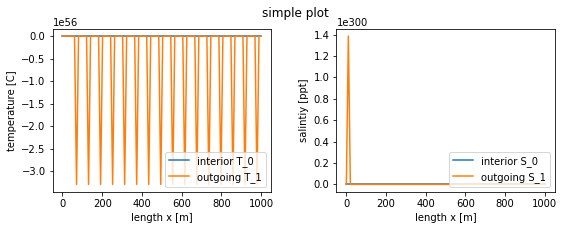

In [27]:
''''''

x=np.linspace(0,steps*dx,steps)

plt.figure(figsize=(9, 3))

plt.subplot(121)
plt.plot(x, T_0, label='interior T_0')
plt.plot(x, T_1, label='outgoing T_1')
plt.xlabel('length x [m]')
plt.ylabel('temperature [C]')
plt.legend(loc='lower right')
plt.subplot(122)
plt.plot(x, S_0, label='interior S_0')
plt.plot(x, S_1, label='outgoing S_1')
plt.xlabel('length x [m]')
plt.ylabel('salintiy [ppt]')
plt.legend(loc='lower right')
plt.suptitle('simple plot')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
#plt.show()
plt.savefig('simpleplot.png', dpi=300, bbox_inches='tight')

'''